https://www.kaggle.com/code/imsparsh/food-classifier-mobilenetv2-resnet50-vgg16

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import random

import tensorflow as tf
from tensorflow.keras import layers as k
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, classification_report

import json
import pickle
from tqdm import tqdm

import cv2
from google.colab.patches import cv2_imshow

import os
import warnings
warnings.filterwarnings('ignore')

import gc

seed = 42

In [3]:
image_size = (224, 224, 3)
batch_num = 32
epoch_num = 100

# create_model_name
model = 'MobileNet2'
numbering = '03'
preprocessing_method ='method4_224'
class_type = 'selected_class'

# 고정 내역
max_pic_cnt = 1000
top_layer = 'customized_top_layer'

model_name = f'{model}_{numbering}_{preprocessing_method}_{class_type}_batch({batch_num})_epoch({epoch_num})'
print(model_name)

MobileNet2_03_method4_224_selected_class_batch(32)_epoch(100)


In [4]:
# create model folder
base_path = f'/content/drive/MyDrive/project3/image_model/{model}'
if not os.path.exists(base_path):
    os.makedirs(base_path)

model_path = f'/content/drive/MyDrive/project3/image_model/{model}/{model_name}'
if not os.path.exists(model_path):
    os.makedirs(model_path)

# result folder
result_path = f'/content/drive/MyDrive/project3/image_model/{model}/{model_name}/result'
if not os.path.exists(result_path):
    os.makedirs(result_path)

### data 준비

In [5]:
def get_image():
    pkl_dir_path = f'/content/drive/MyDrive/project3/data/traindata/image_to_list/{class_type}_square/{preprocessing_method}.pkl'
    df = pd.read_pickle(pkl_dir_path)

    image_list = np.array([x.reshape(224, 224, 3) for x in df['sq_list']])
    target_list = df['small_class']

    image_list = np.array(image_list).astype(np.uint8)
    target_list = np.array(target_list)

    return image_list, target_list


def prepare_data(test_size=0.2, random_state=42):
    # get_image 함수를 통해서 image / target 가져오기
    image_list, target_list = get_image()

    label_encoder = LabelEncoder()
    encoded_target_list = label_encoder.fit_transform(target_list)

    # Train-Test Split
    X_train, X_test, y_train, y_test = train_test_split(image_list, encoded_target_list, test_size=test_size, random_state=random_state)

    # image_array 정규화
    X_train = X_train / 255.0
    X_test = X_test / 255.0

    num_classes = len(np.unique(target_list))

    # target (one-hot encoding)
    y_train = to_categorical(y_train, num_classes)
    y_test = to_categorical(y_test, num_classes)

    return X_train, X_test, y_train, y_test, target_list, label_encoder

# 나중에 다시 label을 출력하기 위한 코드
def decode_labels(encoded_label, label_encoder):
    return label_encoder.inverse_transform(encoded_label)





In [6]:
X_train, X_test, y_train, y_test, target_list, label_encoder = prepare_data()
num_classes = len(np.unique(target_list))

print(f"X_train : {X_train.shape}")
print(f"X_test : {X_test.shape}")
print(f"y_train : {y_train.shape}")
print(f"y_test : {y_test.shape}")
print(f'Target count: {num_classes}')

X_train : (21876, 224, 224, 3)
X_test : (5469, 224, 224, 3)
y_train : (21876, 38)
y_test : (5469, 38)
Target count: 38


Label: 육개장
(224, 224, 3)


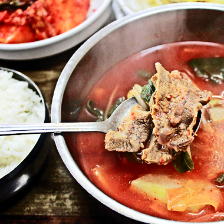

In [7]:
pic_num = 900
decoded_label = decode_labels([np.argmax(y_train[pic_num])], label_encoder)
print(f"Label: {decoded_label[0]}")
print(X_train[pic_num].shape)
cv2_imshow(X_train[pic_num] * 255)


### 모델 설계

In [8]:
# Load the MobileNetV2
# model pre-trained -> by imagenet dataset
# without the top layer -> 마지막 결과를 내는 레이어 층에 관한
mobilenet = MobileNetV2(weights='imagenet', input_shape=[224,224,3], include_top=False)
mobilenet.trainable = False

model = tf.keras.models.Sequential([
                             mobilenet,
                             tf.keras.layers.GlobalAveragePooling2D(),
                             k.Dropout(0.2),
                             k.Dense(256, activation='relu'),
                             k.BatchNormalization(),
                             k.Dropout(0.1),
                             k.Dense(128, activation='relu'),
                             k.BatchNormalization(),
                             k.Dropout(0.1),
                             k.Dense(num_classes, activation='softmax')
])
print(model.summary())

9406464/9406464 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                            

In [9]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(filepath=os.path.join(model_path, f'{model_name}_best.h5'),
                                   monitor='val_loss', save_best_only=True)


model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=[tf.keras.metrics.CategoricalAccuracy(), tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
)

history = model.fit(X_train, y_train, epochs= epoch_num, batch_size= batch_num, validation_split= 0.15,
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/100
582/582 [==============================] - 25s 30ms/step - loss: 1.8587 - categorical_accuracy: 0.4805 - precision: 0.7696 - recall: 0.2943 - val_loss: 1.1404 - val_categorical_accuracy: 0.6603 - val_precision: 0.8230 - val_recall: 0.5283
Epoch 2/100
582/582 [==============================] - 13s 22ms/step - loss: 1.2464 - categorical_accuracy: 0.6314 - precision: 0.7983 - recall: 0.4967 - val_loss: 1.0621 - val_categorical_accuracy: 0.6792 - val_precision: 0.8198 - val_recall: 0.5725
Epoch 3/100
582/582 [==============================] - 12s 20ms/step - loss: 1.1068 - categorical_accuracy: 0.6697 - precision: 0.8096 - recall: 0.5521 - val_loss: 0.9926 - val_categorical_accuracy: 0.6996 - val_precision: 0.8281 - val_recall: 0.6079
Epoch 4/100
582/582 [==============================] - 12s 21ms/step - loss: 1.0230 - categorical_accuracy: 0.6911 - precision: 0.8158 - recall: 0.5854 - val_loss: 0.9738 - val_categorical_accuracy: 0.7057 - val_precision: 0.8233 - val_recall: 0.6

In [10]:
# model save
model.save(os.path.join(model_path, f'{model_name}.h5'))


# training history save
with open(os.path.join(result_path, f'{model_name}_history.json'), 'w') as f:
    json.dump(history.history, f)

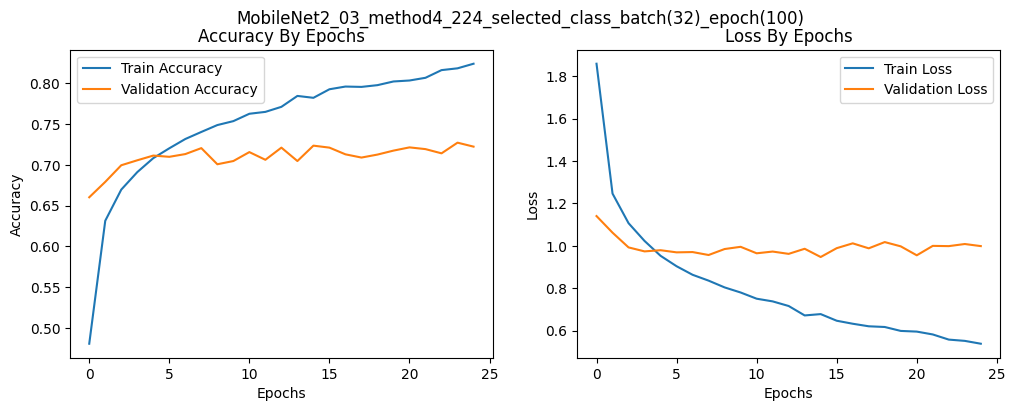

In [11]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['categorical_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy By Epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss By Epochs')

plt.suptitle(f'{model_name}')

# save training_plot
plt.savefig(os.path.join(result_path, f'{model_name}_training_plot.png'))
plt.show()

171/171 [==============================] - 3s 13ms/step
              precision    recall  f1-score   support

           0       0.88      0.62      0.73       135
           1       0.54      0.57      0.55       129
           2       0.69      0.70      0.70       169
           3       0.58      0.50      0.54       125
           4       0.78      0.83      0.80       180
           5       0.87      0.84      0.86       140
           6       0.77      0.72      0.74       131
           7       0.79      0.73      0.76       128
           8       0.68      0.76      0.72       148
           9       0.80      0.69      0.74       147
          10       0.53      0.40      0.45       159
          11       0.78      0.70      0.73       139
          12       0.76      0.87      0.81       157
          13       0.78      0.64      0.70       157
          14       0.47      0.60      0.53       141
          15       0.75      0.60      0.67       164
          16       0.74  

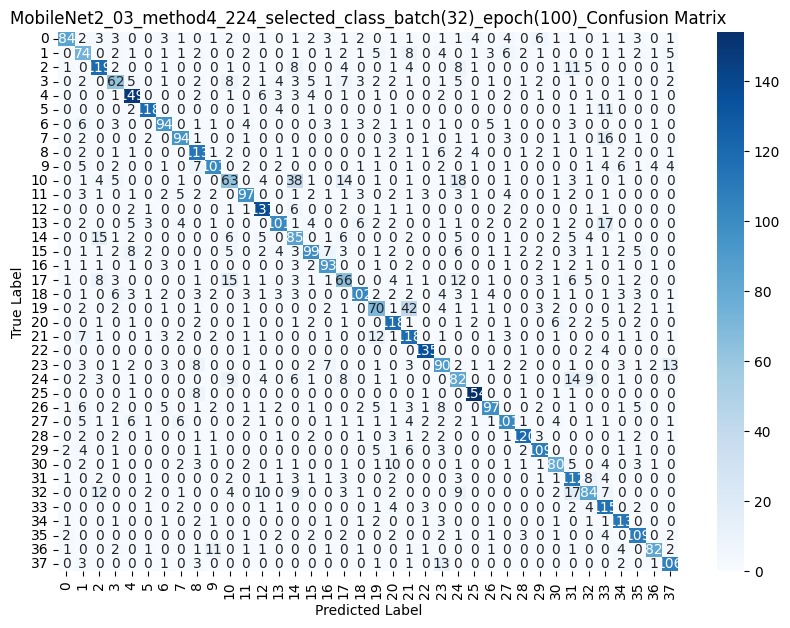

In [12]:

y_pred = model.predict(X_test)

# Convert one-hot encoded predictions and actual values to class labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Print classification report for detailed metrics
class_report = classification_report(y_true_classes, y_pred_classes)
print(class_report)

with open(os.path.join(result_path, f'{model_name}_classification_report.txt'), 'w') as f:
    f.write(class_report)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'{model_name}_Confusion Matrix')

plt.savefig(os.path.join(result_path, f'{model_name}_confusion_matrix.png'))
plt.show()

In [13]:
y_pred_classes

array([26,  1, 21, ..., 29, 24, 21])

In [14]:
y_true_classes

array([26, 30, 21, ..., 29, 24, 27])

In [15]:

# Calculate accuracy using sklearn
accuracy = accuracy_score(y_true_classes, y_pred_classes)
print('Accuracy:', accuracy)

# Calculate precision and recall using sklearn
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
print('Precision:', precision)
print('Recall:', recall)

# Append accuracy to a text file
with open(os.path.join(base_path, 'accuracy.txt'), 'a') as f:
    f.write(f'{model_name}_Accuracy: {accuracy:.2f}%\n')
    f.write(f'{model_name}_Precision: {precision:.2f}%\n')
    f.write(f'{model_name}_Recall: {recall:.2f}%\n')

Accuracy: 0.7032364234777839
Precision: 0.7107209198126409
Recall: 0.7032364234777839


In [16]:
# cnt = 0
# for i in range(len(y_pred_classes)):
#     print('예측 : ', y_pred_classes[i], "실제 :", y_true_classes[i])
#     if y_pred_classes[i] == y_true_classes[i]:
#         cnt += 1
# print('정확도', cnt / len(y_pred_classes) * 100, '%')

# with open(os.path.join(model_path, 'accuracy.txt'), 'w') as f:
#     f.write(f'{model}_Accuracy: {cnt / len(y_pred_classes) * 100:.2f}%\n')